In [2]:
# !pip3 install pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
# !pip3 install torch-geometric
# !pip3 install networkx
# !pip3 install torchkge
# !pip3 install xgboost
# !pip3 install torch
# !pip3 install clearml
# !pip install optuna
# !pip install tensorboard

In [3]:
import clearml
from clearml.automation import UniformParameterRange, UniformIntegerParameterRange
from clearml.automation import HyperParameterOptimizer
from clearml.automation import GridSearch
from clearml.automation.optuna import OptimizerOptuna

%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=1TLQ80F68DX7TYYJD7CJ
%env CLEARML_API_SECRET_KEY=NsPZnOAeABfTPBgQB0bD01Kx6j559C4Kb8hOaGzeeuaFj1tnfx

clearml.browser_login()
from clearml import Task

train_task = Task.init(project_name="msai_devops", 
                 task_name="predict_football_matches", 
                 output_uri=True)
print(train_task)

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=1TLQ80F68DX7TYYJD7CJ
env: CLEARML_API_SECRET_KEY=NsPZnOAeABfTPBgQB0bD01Kx6j559C4Kb8hOaGzeeuaFj1tnfx
ClearML Task: overwriting (reusing) task id=c3fb054ae88a46e18ef839bff22c78dd
2023-05-26 04:56:44,646 - clearml.Repository Detection - WARNING - Could not read Jupyter Notebook: No module named 'nbconvert'
2023-05-26 04:56:44,652 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/e8e3a5048a3b44019547761a45430515/experiments/c3fb054ae88a46e18ef839bff22c78dd/output/log


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


In [14]:
taskid = train_task.id

# Import necessary Libraries

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import requests
import networkx as nx
import torch_geometric
import torchkge
from torchkge.models import TransEModel
from torchkge.models import  ComplExModel
from torchkge.sampling import BernoulliNegativeSampler
from torchkge.utils import MarginLoss, DataLoader
from torchkge.data_structures import KnowledgeGraph
from torch.utils.tensorboard import SummaryWriter
from torch import cuda
from tqdm.autonotebook import tqdm
from torch.optim import Adam
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchkge.utils.pretrained_models import load_pretrained_transe
from torchkge.evaluation import LinkPredictionEvaluator
import pandas as pd
import xgboost as xgb
import time
import warnings
warnings.simplefilter("always")
import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()

# Data Wrangling

In [7]:
def clean_scraped_data_and_split(df):
    df = df_seria_a.copy()
    df.drop(['id', 'notes', 'match report', 'referee', 'captain', 'comp'], axis=1, inplace=True)
    df['attendance'] = df['attendance'].fillna(df['attendance'].mean()).apply(np.round).astype("int")
    df['dist'].fillna(df['dist'].mode()[0], inplace=True)
    df['time'].fillna(df['time'].mode()[0], inplace=True)
    df.fillna(method='ffill', inplace=True)
    print(df.shape)
    df = pd.merge(df, 
                  df[['date','opponent','team', 'formation', 'poss', 'sh', 'sot', 'dist']], 
                  how='inner', 
                  left_on=['date', 'opponent'],
                  right_on=['date', 'team'],
                  suffixes=('_x', '_y'))

    df.drop(['opponent_y', 'team_y'], axis=1, inplace=True)
    df.rename(columns={'team_x':'team', 'opponent_x':'opponent'}, inplace=True)
    print(df.columns, df.shape)

    class Missing_Dict(dict):
        __missing__ = lambda self, key: key

    map_values = {"Internazionale": "Inter",}

    map_teams = Missing_Dict(**map_values)
    df["team"] = df["team"].map(map_teams)
    df["opponent"] = df["opponent"].map(map_teams)
    result_label_as_int = {'W': 2, 'D': 1, 'L': 0}
    df.replace({"result": result_label_as_int}, inplace=True)
    df["date"] = pd.to_datetime(df["date"])
    df["hour"] = df["time"].str.replace(":.+", "", regex=True).astype("int")
    df['day'] = df['date'].dt.day_name()
    df["date"] = df['date'].dt.date.astype("str")
    df.drop(["time"], axis=1, inplace=True)
    match_time_of_day = {20: 'Night', 15: 'Tea_time', 14: 'Lunch_time', 12: 'Lunch_time', 19: 'Night', 17: 'Evening', 16: 'Evening', 18: 'Evening', 13: 'Lunch_time'}
    df.replace({"hour": match_time_of_day}, inplace=True)
    df.rename(columns = {'hour':'time'}, inplace = True)
    df.sort_values(by='date', inplace=True) 
    df["train"] = df.date < '2023-03-01'
    df['test'] = ~df["train"]
    
    return df

df_seria_a = pd.read_csv("../lab02/matches_serie-a.csv", low_memory=True)
cleaned_df = clean_scraped_data_and_split(df_seria_a)

(760, 22)
Index(['date', 'time', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss_x', 'attendance', 'formation_x', 'sh_x',
       'sot_x', 'dist_x', 'fk', 'pk', 'pkatt', 'season', 'team', 'formation_y',
       'poss_y', 'sh_y', 'sot_y', 'dist_y'],
      dtype='object') (722, 27)


# KG Task

## Prepare Data

In [8]:
def generate_triples_df(df):
    triples = []
    for _, row in df.iterrows():
        # match_info
        match_played_date = (row["round"], "was_played_on", row["date"])
        match_played_time = (row["round"], "was_played_at", row["time"])
        match_played_day = (row["round"], "was_played_on_day", row["day"])
        match_played_season = (row["round"], "belonged_to_season", row["season"])

        # Home and away information
        if row["venue"] == 'Home':
            match_attendance = (row["team"], "had_attendance", row["attendance"])
            home_team = (row["team"], "is_home_on", row["round"])
            away_team = (row["opponent"], "is_away_on", row["round"])
            home_team_poss = (row["team"], "has_possession_as", row["poss_x"])
            away_team_poss = (row["opponent"], "has_possession_as", row["poss_y"])
            home_team_shots = (row["team"], "had_total_shots_as", row["sh_x"])
            away_team_shots = (row["opponent"], "had_total_shots_as", row["sh_y"])
            home_team_shots_on_target = (row["team"], "had_shots_on_target_as", row["sot_x"])
            away_team_shots_on_target = (row["opponent"], "had_shots_on_target_as", row["sot_y"])
            home_team_distance_covered = (row["team"], "covered_km_as", row["dist_x"])
            away_team_distance_covered = (row["opponent"], "covered_km_as", row["dist_y"])
            home_team_xg = (row["team"], "has_expected_goals_as", row["xg"])
            away_team_xg = (row["opponent"], "has_expected_goals_as", row["xga"])
            home_team_formation = (row["team"], "had_formation", row["formation_x"])
            away_team_formation = (row["opponent"], "had_formation", row["formation_y"])
        else:
            match_attendance = (row["opponent"], "had_attendance", row["attendance"])
            home_team = (row["opponent"], "is_home_on", row["round"])
            away_team = (row["team"], "is_away_on", row["round"])
            home_team_poss = (row["opponent"], "has_possession_as", row["poss_y"])
            away_team_poss = (row["team"], "has_possession_as", row["poss_x"])
            home_team_shots = (row["opponent"], "had_total_shots_as", row["sh_y"])
            away_team_shots = (row["team"], "had_total_shots_as", row["sh_x"])
            home_team_shots_on_target = (row["opponent"], "had_shots_on_target_as", row["sot_y"])
            away_team_shots_on_target = (row["team"], "had_shots_on_target_as", row["sot_x"])
            home_team_distance_covered = (row["opponent"], "covered_km_as", row["dist_y"])
            away_team_distance_covered = (row["team"], "covered_km_as", row["dist_x"])
            home_team_xg = (row["opponent"], "has_expected_goals_as", row["xga"])
            away_team_xg = (row["team"], "has_expected_goals_as", row["xg"])
            home_team_formation = (row["opponent"], "had_formation", row["formation_y"])
            away_team_formation = (row["team"], "had_formation", row["formation_x"])

        
        triples.extend((match_played_date, 
                        match_played_time, 
                        match_played_day, 
                        match_played_season, 
                        home_team, away_team,
                        home_team_xg, away_team_xg,
                        home_team_poss, away_team_poss,
                        match_attendance, 
                        home_team_formation, away_team_formation, 
                        home_team_shots, away_team_shots, 
                        home_team_shots_on_target, away_team_shots_on_target, 
                        home_team_distance_covered, away_team_distance_covered, 
                        ))
        
    triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
    triples_df.rename(columns = {'subject':'from', 'predicate':'rel', 'object':'to'}, inplace = True)
    triples_df = triples_df[['from', 'to', 'rel']]
    triples_df = triples_df.astype(str)
    print(triples_df.shape)
    return triples_df

triples_df = generate_triples_df(cleaned_df)

(13718, 3)


/home/oozoglu/.local/lib/python3.10/site-packages/clearml/backend_interface/metrics/reporter.py:960: ResourceWarning:

unclosed file <_io.BufferedReader name='/tmp/tmp9y39j7k_.png'>



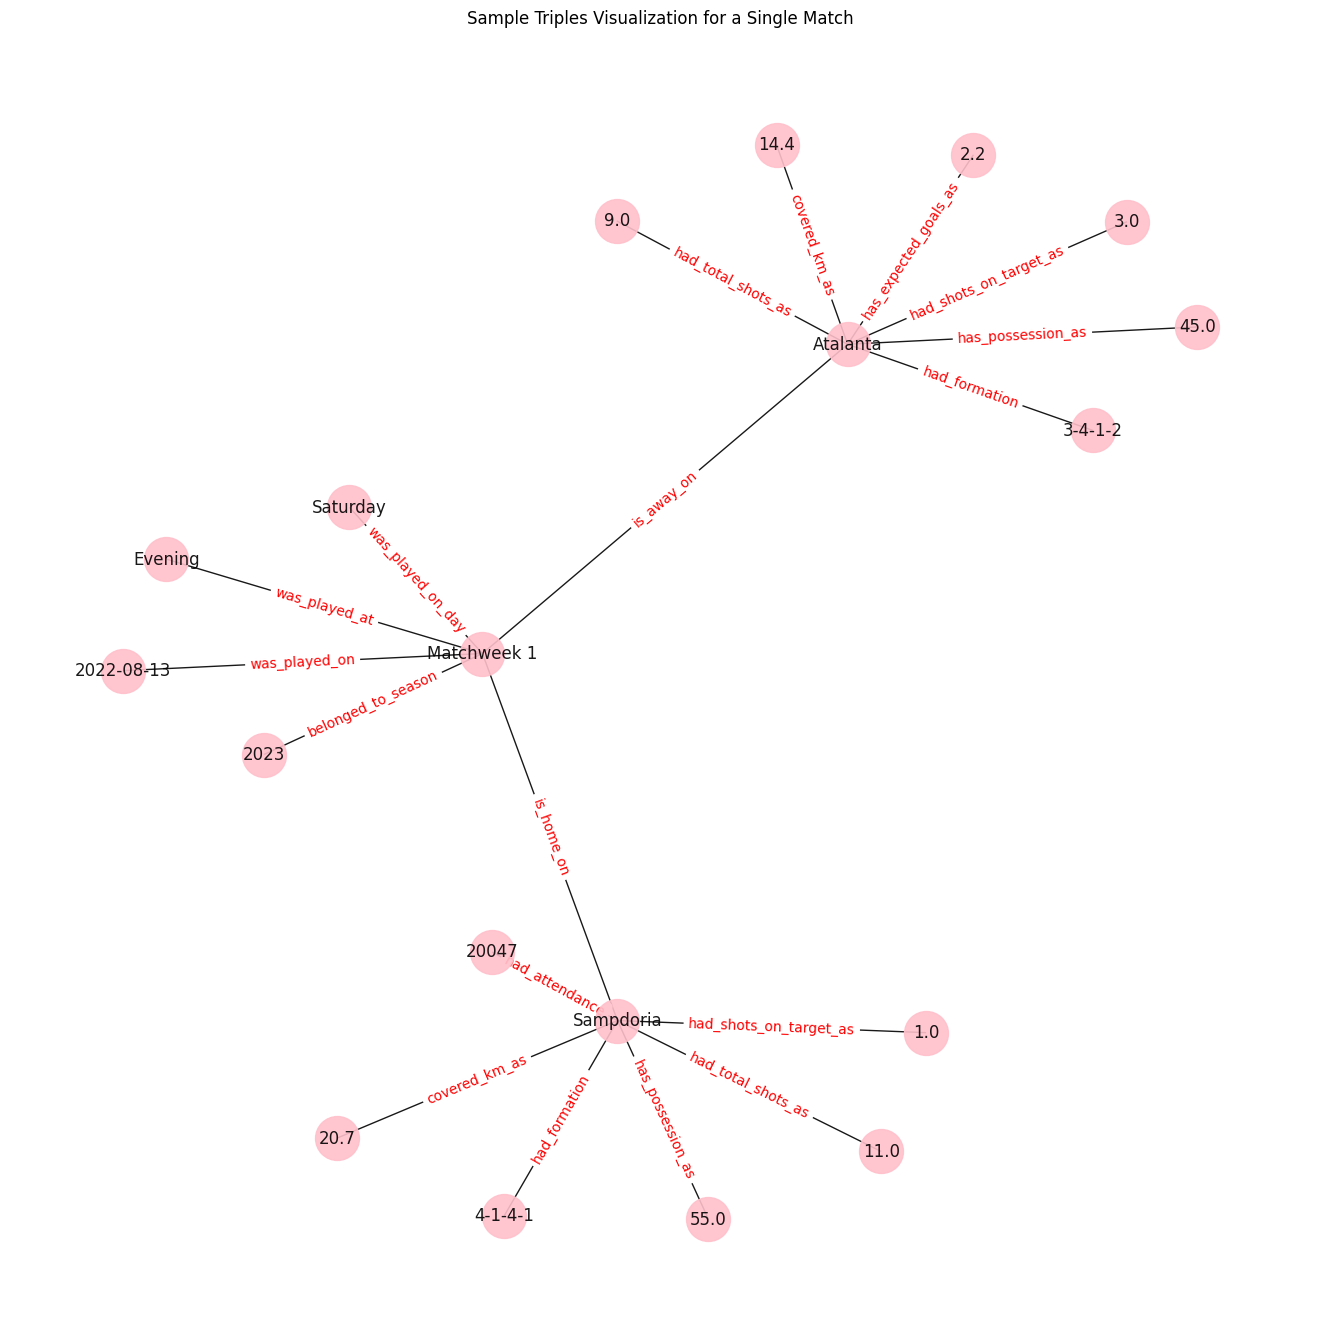

In [9]:
def validate_triples_df(triples_df):
    to_visualize_edges = triples_df[76:95]
    edge_list = []
    edge_labels = {}
    for _, row in to_visualize_edges.iterrows():
        h, r, t = row['from'], row['rel'], row['to']
        edge_list.append([h, t])
        edge_labels[(h, t)] = r

    G = nx.Graph()
    G.add_edges_from(edge_list)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(13, 13))
    nx.draw(
        G, pos, edge_color='black', width=1, linewidths=1,
        node_size=1000, node_color='pink', alpha=0.9,
        labels={node: node for node in G.nodes()}
    )
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_color='red'
    )

    plt.axis('off')
    plt.title('Sample Triples Visualization for a Single Match')
    plt.show()

validate_triples_df(triples_df)

In [10]:
def knowledge_graph_training(kg_train, dataloader, sampler, model, criterion, optimizer, n_epochs):
    
    ent2ix, rel2ix = kg_train.ent2ix, kg_train.rel2ix

    # Use CUDA when available
    if cuda.is_available():
        cuda.empty_cache()
        model.cuda()
        criterion.cuda()
        print("USING CUDA: ", device)
    else:
        print("POOR CPU")

    # training loop
    iterator = tqdm(range(n_epochs), unit='epoch')
    for epoch in iterator:
        running_loss = 0.0
        for i, batch in enumerate(dataloader):
            h, t, r = batch[0], batch[1], batch[2]
            n_h, n_t = sampler.corrupt_batch(h, t, r)

            optimizer.zero_grad()

            # forward + backward + optimize
            if cuda.is_available():
                pos, neg = model(h.cuda(), t.cuda(), r.cuda(), n_h.cuda(), n_t.cuda())
            else:
                pos, neg = model(h, t, r, n_h, n_t)
            loss = criterion(pos, neg)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        writer.add_scalar('eloss', running_loss, epoch * len(dataloader) + i)
        iterator.set_description('Epoch {} | mean loss: {:.5f}'.format(epoch + 1, running_loss / len(dataloader)))

    model.normalize_parameters()
    return model, ent2ix, rel2ix

In [ ]:
params_dict = {
    'emb_dim': 50,
    'lr': 0.005,
    'n_epochs': 200,
    'b_size': 256,
    'margin': 0.5,
    'num_class': 3,
    'objective': "multi:softprob",
    'eval_metric': 'mlogloss',
    'max_depth': 5,
    'eta': 0.1,
    'nthread': 4,
    'colsample_bytree': 0.5,    
    'subsample': 0.5,
    'gamma':0.1,
}
train_task.connect(params_dict)

## KGE Training

In [16]:
emb_dim = params_dict['emb_dim'] # dimension of the tensor in the latent space
lr = params_dict['lr'] # learning rate to make gradient step 
n_epochs = params_dict['n_epochs']# number of epochs
b_size = params_dict['b_size']# size of data for each batch
margin = params_dict['margin'] # margin for the loss function
kg_train: torchkge.data_structures.KnowledgeGraph(triples_df) # generate kg_train
dataloader: DataLoader(kg_train, batch_size=b_size, use_cuda=device)
sampler: BernoulliNegativeSampler(kg_train) # negative sampler
model: TransEModel(emb_dim, kg_train.n_ent, kg_train.n_rel, dissimilarity_type='L2') # Model and loss function
criterion: MarginLoss(margin) # loss function
optimizer: Adam(model.parameters(), lr=lr, weight_decay=1e-5)
trained_model, ent2ix, rel2ix = knowledge_graph_training(kg_train, dataloader, sampler, model, criterion, optimizer, n_epochs)

POOR CPU


Epoch 200 | mean loss: 2.68585: 100%|██████████| 200/200 [00:23<00:00,  8.66epoch/s]


## HyperParameter Optimization for KG Task

In [ ]:
params_dict = {
    'emb_dim': 50,
    'lr': 0.005,
    'n_epochs': 200,
    'b_size': 256,
    'margin': 0.5,
    'num_class': 3,
    'objective': "multi:softprob",
    'eval_metric': 'mlogloss',
    'max_depth': 5,
    'eta': 0.1,
    'nthread': 4,
    'colsample_bytree': 0.5,    
    'subsample': 0.5,
    'gamma':0.1,
}

In [ ]:
opt1 = HyperParameterOptimizer(
    base_task_id=taskid,
    hyper_parameters=[
        UniformIntegerParameterRange('General/emb_dim', min_value=64, max_value=128, step_size=32),
        UniformParameterRange('General/lr', min_value=0.001, max_value=0.1, step_size=0.03),
        UniformIntegerParameterRange('General/n_epochs', min_value=100, max_value=300, step_size=100),
        UniformIntegerParameterRange('General/b_size', min_value=64, max_value=256, step_size=64),
        UniformParameterRange('General/margin', min_value=0.5, max_value=0.7, step_size=0.1),
    ],
    objective_metric_title='eloss',
    objective_metric_series='eloss',
    objective_metric_sign='min',
    optimizer_class=OptimizerOptuna,
    max_number_of_concurrent_tasks=7,
    optimization_time_limit=10.,
    compute_time_limit=45,
    total_max_jobs=20,
    min_iteration_per_job=15000,
    max_iteration_per_job=150000,)

opt1.set_report_period(0.15)
opt1.start()  
opt1.wait() 
opt1.stop()

In [25]:
top_3_experiments = opt1.get_top_experiments(top_k=3)
print("The Top 3 Experiments which can be conducted with HyperParametes are:")
for n, t in enumerate(top_3_experiments, 1):
    print(f"Rank = {n}: task_id = {t.id} with {t.get_parameters()}")

The Top 3 Experiments which can be conducted with HyperParametes are:
Rank = 1: task_id = 52de62f1f3964c9fabf7bc426868da52 with {'General/emb_dim': '128', 'General/lr': '0.031', 'General/n_epochs': '300', 'General/b_size': '128', 'General/margin': '0.6', 'General/num_class': '3', 'General/objective': 'multi:softprob', 'General/eval_metric': 'mlogloss', 'General/max_depth': '5', 'General/eta': '0.1', 'General/nthread': '4', 'General/colsample_bytree': '0.5', 'General/subsample': '0.5', 'General/gamma': '0.1', 'General/opt/base_task_id': 'c3fb054ae88a46e18ef839bff22c78dd', 'General/opt/objective_metric_title': 'eloss', 'General/opt/objective_metric_series': 'eloss', 'General/opt/objective_metric_sign': 'min', 'General/opt/max_number_of_concurrent_tasks': '7', 'General/opt/execution_queue': 'default', 'General/opt/optimization_time_limit': '10.0', 'General/opt/compute_time_limit': '45', 'General/opt/optimizer_kwargs/total_max_jobs': '20', 'General/opt/optimizer_kwargs/min_iteration_per_jo

# XGB Task

## Prepare data

In [26]:
def prep_process_for_prediction(df, model, ent2ix, rel2ix):
    ent_emb, rel_emb = model.get_embeddings()

    entity_embedding_dict = {}
    for k, v in ent2ix.items():
        entity_embedding_dict[k] = ent_emb[v].cpu().numpy()

    relation_embedding_dict = {}
    for k, v in rel2ix.items():
        relation_embedding_dict[k] = rel_emb[v].cpu().numpy()

    def get_embeddings(team):
        return entity_embedding_dict.get(team, np.full(200, np.nan))

    def get_features_target(mask):
        features = np.hstack((np.vstack(df[mask].team.apply(get_embeddings).values),
                      np.vstack(df[mask].opponent.apply(get_embeddings).values)))
        response = df[mask].result.values
        return features, response

    clf_X_train, y_train = get_features_target((df["train"]))
    clf_X_test, y_test = get_features_target((df["test"]))

    return clf_X_train, y_train, clf_X_test, y_test


clf_X_train, y_train, clf_X_test, y_test = prep_process_for_prediction(cleaned_df, trained_model, ent2ix, rel2ix)
print(clf_X_train.shape, y_train.shape, clf_X_test.shape, y_test.shape)

def get_data_to_correct_format_for_xgb(clf_X_train, y_train, clf_X_test, y_test):
    dtrain = xgb.DMatrix(clf_X_train, label=y_train)
    dtest = xgb.DMatrix(clf_X_test, label=y_test)
    return dtrain, dtest

dtrain, dtest = get_data_to_correct_format_for_xgb(clf_X_train, y_train, clf_X_test, y_test)

(456, 100) (456,) (266, 100) (266,)


## Classification Task

In [27]:
hyper_params = {
    'num_class': 3,
    'objective': "multi:softprob",
    'eval_metric': 'mlogloss',
    'max_depth': 5,
    'eta': 0.1,
    'nthread': 4,
    'colsample_bytree': 0.5,    
    'subsample': 0.5,
    'gamma':0.1,
}

In [ ]:
clf_model = xgb.train(hyper_params, 
                      dtrain, 
                      num_boost_round=151, 
                      evals=[(dtrain, "train"), (dtest, "test")],
                      verbose_eval=0,
                    )
clf_model.save_model("best_model")

accuracy = 0.29699248120300753
result
0    0.402256
2    0.342105
1    0.255639
Name: proportion, dtype: float64


/home/oozoglu/.local/lib/python3.10/site-packages/clearml/utilities/locks/utils.py:326: ResourceWarning:

unclosed file <_io.TextIOWrapper name='/tmp/clearml_c3fb054ae88a46e18ef839bff22c78dd.lock' mode='a' encoding='UTF-8'>

/home/oozoglu/.local/lib/python3.10/site-packages/clearml/utilities/locks/utils.py:326: ResourceWarning:

unclosed file <_io.TextIOWrapper name='/tmp/clearml_c3fb054ae88a46e18ef839bff22c78dd.lock' mode='a' encoding='UTF-8'>

/home/oozoglu/.local/lib/python3.10/site-packages/clearml/utilities/locks/utils.py:326: ResourceWarning:

unclosed file <_io.TextIOWrapper name='/tmp/clearml_c3fb054ae88a46e18ef839bff22c78dd.lock' mode='a' encoding='UTF-8'>

/home/oozoglu/.local/lib/python3.10/site-packages/clearml/utilities/locks/utils.py:326: ResourceWarning:

unclosed file <_io.TextIOWrapper name='/tmp/clearml_c3fb054ae88a46e18ef839bff22c78dd.lock' mode='a' encoding='UTF-8'>

/home/oozoglu/.local/lib/python3.10/site-packages/clearml/utilities/locks/utils.py:326: ResourceWarn

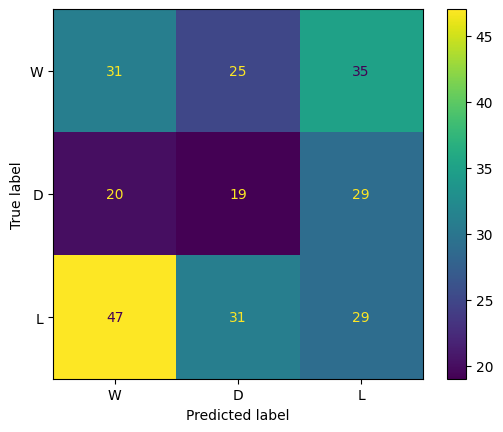

sys:1: ResourceWarning:

Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbbccf413c0>

sys:1: ResourceWarning:

Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbaf47ab8e0>

sys:1: ResourceWarning:

Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fbafc9acfa0>



In [29]:
def predict_match_result_display(df, dtest, clf_model):
    y_pred_probas = clf_model.predict(dtest)
    y_preds = np.argmax(y_pred_probas, axis=1)
    print(f'accuracy = {accuracy_score(y_test, y_preds)}')

    result_label_as_int = {'W': 2, 'D': 1, 'L': 0}
    print(df[df["test"]].result.value_counts(normalize=True))
    int_to_result = {v: k for k, v in result_label_as_int.items()}
    y_test_str = [int_to_result[outcome] for outcome in y_test]
    y_preds_str = [int_to_result[outcome] for outcome in y_preds]

    cm = confusion_matrix(y_test_str, y_preds_str, labels=['W','D','L'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['W','D','L'])
    disp.plot()
    plt.show()

predict_match_result_display(cleaned_df, dtest, clf_model)
train_task.close()

## Hyper-parameters Optimization for XGB Task

In [ ]:
hyper_params = {
    'num_class': 3,
    'objective': "multi:softprob",
    'eval_metric': 'mlogloss',
    'max_depth': 5,
    'eta': 0.1,
    'nthread': 4,
    'colsample_bytree': 0.5,    
    'subsample': 0.5,
    'gamma':0.1,
}

In [ ]:
opt2 = HyperParameterOptimizer(
    base_task_id=taskid,
    hyper_parameters=[
        UniformParameterRange('General/gamma', min_value=0.1, max_value=0.3, step_size=0.1),
        UniformParameterRange('General/eta', min_value=0.001, max_value=0.1, step_size=50),
        UniformParameterRange('General/colsample_bytree', min_value=0.5, max_value=1, step_size=0.1),
        UniformParameterRange('General/subsample', min_value=0.5, max_value=1, step_size=0.1),
        UniformIntegerParameterRange('General/max_depth', min_value=3, max_value=7, step_size=2),        
    ],
    objective_metric_title='train',
    objective_metric_series='mlogloss',
    objective_metric_sign='min',
    optimizer_class=GridSearch,
    max_number_of_concurrent_tasks=7,
    optimization_time_limit=10,
    compute_time_limit=30,
    total_max_jobs=20,

)

opt2.set_report_period(0.15)
opt2.start()  
opt2.wait()
opt2.stop()

In [31]:
top_3_experiments = opt2.get_top_experiments(top_k=3)
print("The Top 3 Experiments which can be conducted with HyperParametes are:")
for n, t in enumerate(top_3_experiments, 1):
    print(f"Rank = {n}: task_id = {t.id} with {t.get_parameters()}")

The Top 3 Experiments which can be conducted with HyperParametes are:
Rank = 1: task_id = 7a85a046cdbe44eead4d5385ab2ee761 with {'General/emb_dim': '50', 'General/lr': '0.005', 'General/n_epochs': '200', 'General/b_size': '256', 'General/margin': '0.5', 'General/num_class': '3', 'General/objective': 'multi:softprob', 'General/eval_metric': 'mlogloss', 'General/max_depth': '3', 'General/eta': '0.1', 'General/nthread': '4', 'General/colsample_bytree': '0.5', 'General/subsample': '0.5', 'General/gamma': '0.1', 'General/opt/base_task_id': 'c3fb054ae88a46e18ef839bff22c78dd', 'General/opt/objective_metric_title': 'eloss', 'General/opt/objective_metric_series': 'eloss', 'General/opt/objective_metric_sign': 'min', 'General/opt/max_number_of_concurrent_tasks': '7', 'General/opt/execution_queue': 'default', 'General/opt/optimization_time_limit': '10.0', 'General/opt/compute_time_limit': '45', 'General/opt/optimizer_kwargs/total_max_jobs': '20', 'General/opt/optimizer_kwargs/min_iteration_per_job